## The dataset
Kickstarter is one of the main online crowdfunding platforms in the world. The dataset provided contains more de 300,000 projects launched on the platform in 2018. In the `data.csv` file there are the following columns:

- **ID**: internal ID, _numeric_
- **name**: name of the project, _string_
- **category**: project's category, _string_
- **main_category**: campaign's category, _string_
- **currency**: project's currency, _string_
- **deadline**: project's deadline date, _timestamp_
- **goal**: fundraising goal, _numeric_
- **launched**: project's start date, _timestamp_
- **pledged**: amount pledged by backers (project's currency), _numeric_
- **state**: project's current state, _string_; **this is what you have to predict**
- **backers**: amount of poeple that backed the project, _numeric_
- **country**: project's country, _string_
- **usd pledged**: amount pledged by backers converted to USD (conversion made by KS), _numeric_
- **usd_pledged_real**: amount pledged by backers converted to USD (conversion made by fixer.io api), _numeric_
- **usd_goal_real**: fundraising goal is USD, _numeric_

## Goal
Goal is to predict whether a project will be successful or not. 
1. Find out, which features you will use and which model. 
2. By performance metrics find out when/which the model is good enough. 

# Project Info

#### This notebook only holds the analysis, training and testing code. However current directory has other python files which has to be used for the testing purpose. [training.py, testing.py]

In [1]:
# Required Library Imports
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelBinarizer
import collections
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from tqdm import tqdm
import pickle
from keras.models import load_model

/Users/anilnayak/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


In [2]:
#loading data.csv
data_frame = pd.read_csv('data.csv')
data_frame.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [3]:
data_frame.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

In [4]:
data_frame.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


# Cleaning Data
1. This is the very crucial stage before we start the data analysis. Here we will clean the unnecessary data values.
2. Clean all Null, NaN values, which does not hold any useful information for our data analysis

### This cleaning can be done in many ways.
1. Remove the rows where any column has Null, NaN values
2. If any column has Null or NaN values, we will replace that Null and NaN with the proper value. We can fill by taking distribution of the column values.
3. We can fill the int values with 0 (zero).

In [5]:
data_frame = data_frame[['category','main_category','currency',
                         'deadline','goal', 'launched', 'pledged','state', 
                         'backers','usd pledged', 'usd_pledged_real', 'usd_goal_real']]

In [6]:
data_frame.isnull().values.any()

True

In [7]:
data_frame.state.unique()
# assuming apart from 'successful' all other are unsuccessful

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)

### Finding Null or nan and fill with data

In [8]:
# finding Null valued rows
data_frame[data_frame.isnull().any(axis=1)][0:10]

,category,main_category,currency,deadline,goal,launched,pledged,state,backers,usd pledged,usd_pledged_real,usd_goal_real
169,Film & Video,Film & Video,USD,2014-09-20,6500.0,2014-08-06 21:28:36,555.00,undefined,0,NaN,555.00,6500.00
328,Music,Music,AUD,2015-08-25,4500.0,2015-08-04 12:05:17,4767.00,undefined,0,NaN,3402.08,3211.53
632,Music,Music,USD,2015-04-09,3500.0,2015-03-10 20:06:13,3576.00,undefined,0,NaN,3576.00,3500.00
647,Music,Music,USD,2015-11-26,6000.0,2015-11-02 22:09:19,7007.80,undefined,0,NaN,7007.80,6000.00
749,Music,Music,USD,2016-03-21,3000.0,2016-02-23 03:09:49,3660.38,undefined,0,NaN,3660.38,3000.00
824,Music,Music,CAD,2014-10-10,4000.0,2014-09-10 22:51:01,4760.00,undefined,0,NaN,4251.14,3572.39
844,Music,Music,USD,2015-06-11,5000.0,2015-05-15 02:12:35,6370.00,undefined,0,NaN,6370.00,5000.00
864,Film & Video,Film & Video,USD,2015-11-07,6000.0,2015-10-10 18:45:24,6695.00,undefined,0,NaN,6695.00,6000.00
870,Music,Music,USD,2015-03-28,2750.0,2015-02-11 19:28:27,2926.00,undefined,0,NaN,2926.00,2750.00
890,Music,Music,USD,2015-12-11,1200.0,2015-11-11 21:02:55,1585.00,undefined,0,NaN,1585.00,1200.00


In [9]:
data_frame.isnull().any()

category            False
main_category       False
currency            False
deadline            False
goal                False
launched            False
pledged             False
state               False
backers             False
usd pledged          True
usd_pledged_real    False
usd_goal_real       False
dtype: bool

In [10]:
data_frame = data_frame.fillna(0.0)
data_frame.isnull().any()

category            False
main_category       False
currency            False
deadline            False
goal                False
launched            False
pledged             False
state               False
backers             False
usd pledged         False
usd_pledged_real    False
usd_goal_real       False
dtype: bool

In [11]:
data_frame.head()

,category,main_category,currency,deadline,goal,launched,pledged,state,backers,usd pledged,usd_pledged_real,usd_goal_real
0,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,0.0,0.0,1533.95
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,100.0,2421.0,30000.00
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,220.0,220.0,45000.00
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,1.0,1.0,5000.00
4,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,1283.0,1283.0,19500.00


In [12]:
data_frame.dtypes

category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                object
backers               int64
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

In [13]:
# from sklearn import preprocessing
# d_norm = preprocessing.normalize(data_frame)

# Separate Categorical and Continuous Data
1. In Data analysis the Categorical and Continuous datas are handled in different manner.
2. Continuous - should be normalized.
3. Categorical - should be categories to some const values. In case of date, we can split the dates to MM, DD, YYYY values and use for data analysis

In [14]:
categorical_data = data_frame.select_dtypes(include=['object']).copy()
continuous_data = data_frame.select_dtypes(include=['float','int']).copy()

In [15]:
categorical_data.head()

,category,main_category,currency,deadline,launched,state
0,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed
1,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed
2,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed
3,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,failed
4,Film & Video,Film & Video,USD,2015-08-29,2015-07-04 08:35:03,canceled


In [16]:
continuous_data.head()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
0,1000.0,0.0,0,0.0,0.0,1533.95
1,30000.0,2421.0,15,100.0,2421.0,30000.00
2,45000.0,220.0,3,220.0,220.0,45000.00
3,5000.0,1.0,1,1.0,1.0,5000.00
4,19500.0,1283.0,14,1283.0,1283.0,19500.00


## Cardinality 
1. Cardinality refers to the number of values in a set
2. Finding out the high cardinality columns. The high cadinality values can be converted to could of unique values, which will reduce the feature space.

In [17]:
# high cardinality 
category_stat = categorical_data['category'].value_counts()
main_category_stat = categorical_data['main_category'].value_counts()
currency_stat = categorical_data['currency'].value_counts()

# ordinal features
state_stat = categorical_data['state'].value_counts()

# date column
deadline_stat = categorical_data['deadline'].value_counts()
launched_stat = categorical_data['launched'].value_counts()

In [18]:
categorical_data.deadline.head()

0    2015-10-09
1    2017-11-01
2    2013-02-26
3    2012-04-16
4    2015-08-29
Name: deadline, dtype: object

## Date Column split -  Year and Month

In [19]:
# date Data
df_deadline = pd.DataFrame(categorical_data.deadline.str.split('-').tolist(), columns = ['year_deadline',
																						 'month_deadline',
																						 'date'])[['year_deadline','month_deadline']]
df_launched = pd.DataFrame(categorical_data.launched.str.split('-').tolist(), columns = ['year_launched',
																						 'month_launched',
																						 'date'])[['year_launched','month_launched']]

In [20]:
df_deadline.head()

,year_deadline,month_deadline
0,2015,10
1,2017,11
2,2013,02
3,2012,04
4,2015,08


In [21]:
df_launched.head()

,year_launched,month_launched
0,2015,08
1,2017,09
2,2013,01
3,2012,03
4,2015,07


# Visualizations
1. This is important to vidualize your data, before proceeding to next step.
2. See the distribution of the data.
3. Find how to normalize or split the data for dta analysis.

In [22]:
import matplotlib.pyplot as plt
def plot_category(data):
    plt.bar(data.index, data.values, align='center', alpha=0.5)
    # plt.xticks(category_stat.index, objects)
    plt.ylabel('Usage')
    plt.title('Categories')
    plt.show()

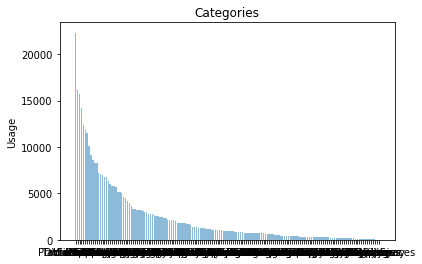

In [23]:
plot_category(category_stat)

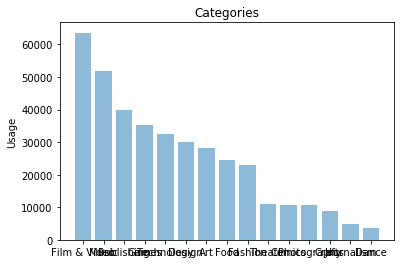

In [24]:
plot_category(main_category_stat)

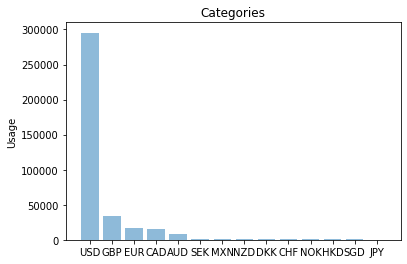

In [25]:
plot_category(currency_stat)

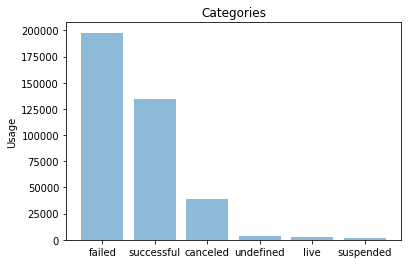

In [26]:
plot_category(state_stat)

In [27]:
np.mean(continuous_data).values

array([49080.79152057,  9682.97933946,   105.61747579,  6966.16849911,
        9058.92407412, 45454.40146545])

In [28]:
np.std(continuous_data).values

array([1.18338970e+06, 9.56358837e+04, 9.07183837e+02, 7.82475109e+04,
       9.09732230e+04, 1.15294853e+06])

In [29]:
continuous_data.values

array([[1.00000e+03, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.53395e+03],
       [3.00000e+04, 2.42100e+03, 1.50000e+01, 1.00000e+02, 2.42100e+03,
        3.00000e+04],
       [4.50000e+04, 2.20000e+02, 3.00000e+00, 2.20000e+02, 2.20000e+02,
        4.50000e+04],
       ...,
       [1.50000e+04, 2.00000e+01, 1.00000e+00, 2.00000e+01, 2.00000e+01,
        1.50000e+04],
       [1.50000e+04, 2.00000e+02, 6.00000e+00, 2.00000e+02, 2.00000e+02,
        1.50000e+04],
       [2.00000e+03, 5.24000e+02, 1.70000e+01, 5.24000e+02, 5.24000e+02,
        2.00000e+03]])

# Data normalizations
1. I have used Mean and std normalization
2. Continuous Data range from -1 to +1
3. Normalization to improve the gradient descent to work efficiently


In [30]:
def normalize_continuous_data(continuous_data):
    # scaler = StandardScaler()
    # scaler.fit(continuous_data)
    mean_data = np.mean(continuous_data).values
    std_data = np.std(continuous_data).values
    continuous_data = (continuous_data.values - mean_data) / std_data
    continuous_data = pd.DataFrame({'goal':continuous_data[:,0],
                                    'pledged':continuous_data[:,1],
                                    'backers':continuous_data[:,2],
                                   'usd pledged':continuous_data[:,3],
                                   'usd_pledged_real':continuous_data[:,4],
                                   'usd_goal_real':continuous_data[:,5]})
    continuous_data = continuous_data[['goal', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real','usd_goal_real']]
    pickle.dump({"mean_data": mean_data, "std_data": std_data}, open("mean_std.pkl", "wb"))

    return continuous_data

In [31]:
# Normalize Continuous Data
continuous_data = normalize_continuous_data(continuous_data)

In [32]:
continuous_data.head()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
0,-0.040630,-0.101248,-0.116423,-0.089027,-0.099578,-0.038094
1,-0.016124,-0.075934,-0.099889,-0.087749,-0.072966,-0.013404
2,-0.003448,-0.098948,-0.113117,-0.086216,-0.097160,-0.000394
3,-0.037250,-0.101238,-0.115321,-0.089015,-0.099567,-0.035088
4,-0.024997,-0.087833,-0.100991,-0.072631,-0.085475,-0.022511


## Find correlation of data columns
1. Find the correlation values of continuous data columns
2. Remove the highly correlated values, because this feature/values will not affect much for our model building for data analysis.

In [33]:
continuous_data.cov()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
goal,1.000003,0.007358,0.004012,0.005567,0.005104,0.942694
pledged,0.007358,1.000003,0.717081,0.856431,0.952845,0.005024
backers,0.004012,0.717081,1.000003,0.697457,0.752541,0.004517
usd pledged,0.005567,0.856431,0.697457,1.000003,0.906641,0.006204
usd_pledged_real,0.005104,0.952845,0.752541,0.906641,1.000003,0.005596
usd_goal_real,0.942694,0.005024,0.004517,0.006204,0.005596,1.000003


In [34]:
continuous_data.corr()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
goal,1.000000,0.007358,0.004012,0.005567,0.005104,0.942692
pledged,0.007358,1.000000,0.717079,0.856429,0.952843,0.005024
backers,0.004012,0.717079,1.000000,0.697455,0.752539,0.004517
usd pledged,0.005567,0.856429,0.697455,1.000000,0.906639,0.006204
usd_pledged_real,0.005104,0.952843,0.752539,0.906639,1.000000,0.005596
usd_goal_real,0.942692,0.005024,0.004517,0.006204,0.005596,1.000000


In [35]:
# continuous_data_after_corr = continuous_data[['goal','pledged','backers','usd pledged']]
# continuous_data_after_corr.corr()

# All variable keep 
# 200 category - one hot - dummy trap drop - first equal true - underfit
# date time = month,year = on hot encode
# time - one hot encode = hr
# target - status - 1,0 - distribution check - uniform distribution
# logistic regression - NN
# randomized - unsuccessful and successful 
# modeling bentch mark = random forest [non smooth linear], SVM [] 

In [36]:
categorical_data.head()

,category,main_category,currency,deadline,launched,state
0,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,failed
1,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,failed
2,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,failed
3,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,failed
4,Film & Video,Film & Video,USD,2015-08-29,2015-07-04 08:35:03,canceled


## Convert the Categorical Data
1. Convert the categorical data to one hot encoding, which can be feed to the model for training or data analysis.

In [37]:
def one_hot_encoding(name, categorical_data, data, dict_categories):
	cat_data = categorical_data[name]
	lb = LabelBinarizer()
	lb_results = lb.fit_transform(cat_data)
	lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)
	
	data = pd.concat([data, lb_results_df], axis = 1)
	
	classes = lb.classes_
	dict_data = collections.defaultdict(int)
	j = 0
	for i in classes:
		dict_data[i.lower()] = j
		j+=1
	dict_categories[name] = dict(dict_data)
	
	return data

In [38]:
# convert onhot encoding for categorical data
dict_categories = {}
data = continuous_data
data = one_hot_encoding('category',categorical_data,data,dict_categories)
data = one_hot_encoding('main_category',categorical_data,data,dict_categories)
data = one_hot_encoding('currency',categorical_data,data,dict_categories)
data = one_hot_encoding('year_deadline',df_deadline,data,dict_categories)
data = one_hot_encoding('month_deadline',df_deadline,data,dict_categories)
data = one_hot_encoding('year_launched',df_launched,data,dict_categories)
data = one_hot_encoding('month_launched',df_launched,data,dict_categories)

In [39]:
pickle.dump(dict_categories, open("categorical.pkl", "wb"))

In [40]:
# Decode Target Data
data = pd.concat([data, categorical_data['state']], axis = 1)
values = categorical_data['state'].astype('category').cat.categories.tolist()
state_dict = collections.defaultdict(int)
state_map_comp = {}
for i in values:
	if i.lower() == 'successful':
		j = 1
	else:
		j = 0
	state_dict[i.lower()] = j
dict_categories['state'] = dict(state_dict)
state_map_comp['state'] = dict(state_dict)
data.replace(state_map_comp, inplace=True)

In [41]:
data.head()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,3D Printing,Academic,Accessories,Action,...,04,05,06,07,08,09,10,11,12,state
0,-0.040630,-0.101248,-0.116423,-0.089027,-0.099578,-0.038094,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,-0.016124,-0.075934,-0.099889,-0.087749,-0.072966,-0.013404,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,-0.003448,-0.098948,-0.113117,-0.086216,-0.097160,-0.000394,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.037250,-0.101238,-0.115321,-0.089015,-0.099567,-0.035088,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.024997,-0.087833,-0.100991,-0.072631,-0.085475,-0.022511,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [42]:
data1 = data

In [43]:
data = shuffle(data)
data.head()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,3D Printing,Academic,Accessories,Action,...,04,05,06,07,08,09,10,11,12,state
129729,-0.038940,-0.100673,-0.114219,-0.088599,-0.098888,-0.036455,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
157391,-0.034038,-0.087415,-0.084456,-0.072119,-0.085035,-0.031792,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
270855,-0.024574,-0.101248,-0.116423,-0.089027,-0.099578,-0.022078,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
247626,-0.036405,-0.100360,-0.109810,-0.088657,-0.098644,-0.034220,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
376804,-0.037250,-0.099837,-0.112014,-0.087302,-0.098094,-0.035088,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


# Split Training and Testing Data

In [44]:
data = data.values

In [45]:
np.shape(data)

(378661, 240)

In [46]:
features = np.shape(data)[1]-1

In [47]:
train, test = train_test_split(data, test_size=0.2)

In [48]:
np.shape(train[:,0:features])

(302928, 239)

In [49]:
X_train = train[:,0:features]
Y_train = train[:,features:]

In [50]:
validation, test = train_test_split(test, test_size=0.5)

In [51]:
X_validation = validation[:,0:features]
Y_validation = validation[:,features:]
X_test = test[:,0:features]
Y_test = test[:,features:]

In [52]:
print("X Train shape " , np.shape(X_train))
print("Y Train shape ", np.shape(Y_train))
print("X Validation shape ", np.shape(X_validation))
print("Y Validation shape ", np.shape(Y_validation))
print("X Test shape " ,np.shape(X_test))
print("Y Test shape ", np.shape(Y_test))
print(len(X_train))

X Train shape  (302928, 239)
Y Train shape  (302928, 1)
X Validation shape  (37866, 239)
Y Validation shape  (37866, 1)
X Test shape  (37867, 239)
Y Test shape  (37867, 1)
302928


# Train Bentchmark Model RandomForest

In [53]:
clf_RandomForest = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
clf_RandomForest.fit(X_train, Y_train)

/Users/anilnayak/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [54]:
clf_RandomForest.feature_importances_[0:10]

array([1.27431481e-01, 1.10871449e-01, 1.41405989e-01, 1.56995174e-01,
       2.64591138e-01, 1.14696469e-01, 8.32639402e-05, 4.34753770e-05,
       1.28242752e-04, 4.82773677e-05])

In [55]:
scores = cross_val_score(clf_RandomForest, X_validation, Y_validation)
scores_test = cross_val_score(clf_RandomForest, X_test, Y_test)

/Users/anilnayak/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/anilnayak/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/anilnayak/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/anilnayak/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:516: DataConversionWa

In [56]:
print("Random Forest score validation ", scores)
print("Random Forest score test ", scores_test)

Random Forest score validation  [0.98177929 0.98177785 0.98241027]
Random Forest score test  [0.98138319 0.97987641 0.97979718]


In [57]:
joblib.dump(clf_RandomForest, 'random_forest_model_385_features.pkl')

['random_forest_model_385_features.pkl']

# Deep Neural Network MLP

In [58]:
import tensorflow.compat.v1 as tf
tf.compat.v1.enable_eager_execution()
tf.disable_v2_behavior()  # this is because the tensorflow 2.0 has not tf.Placeholder()
import numpy as np

Instructions for updating:
non-resource variables are not supported in the long term


In [59]:
n_classes = 1
x = tf.placeholder(tf.float32, shape=[None, features], name='input_tensor')
y = tf.placeholder(tf.float32, shape=[None, n_classes], name='output_tensor')

def neural_network_model(x):
    
    n_nodes_hl1 = 300
    n_nodes_hl2 = 300
    n_nodes_hl3 = 200
    
    
    hidden_1_layer = {'weights':tf.Variable(tf.random_normal([features, n_nodes_hl1])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl1]))}

    hidden_2_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl1, n_nodes_hl2])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl2]))}

    hidden_3_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl2, n_nodes_hl3])),
                      'biases':tf.Variable(tf.random_normal([n_nodes_hl3]))}
    
    output_layer = {'weights':tf.Variable(tf.random_normal([n_nodes_hl3, n_classes])),
                      'biases':tf.Variable(tf.random_normal([n_classes]))}
    
    l1 = tf.add(tf.matmul(x, hidden_1_layer['weights']), hidden_1_layer['biases'])
    l1 = tf.layers.batch_normalization(l1)
    l1 = tf.nn.relu(l1)

    l2 = tf.add(tf.matmul(l1, hidden_2_layer['weights']), hidden_2_layer['biases'])
    l2 = tf.layers.batch_normalization(l2)
    l2 = tf.nn.relu(l2)
    
    l3 = tf.add(tf.matmul(l2, hidden_3_layer['weights']), hidden_3_layer['biases'])
    l3 = tf.layers.batch_normalization(l3)
    l3 = tf.nn.relu(l3)
    
    output = tf.add(tf.matmul(l3, output_layer['weights']), output_layer['biases'])
    
    return output

prediction = neural_network_model(x)
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=prediction, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

predicted = tf.nn.sigmoid(prediction)
correct_pred = tf.equal(tf.round(predicted), y)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

hm_epochs = 5
batch_size = 100

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(hm_epochs):
        epoch_loss = 0
        start = 0
        
        for batch in range(len(X_train)//batch_size):
            batch_x = X_train[start:start+batch_size]
            batch_y = Y_train[start:start+batch_size]
            start += batch_size
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y})
            epoch_loss += c
            
        acc, p = sess.run([accuracy, tf.round(predicted)], feed_dict={x: X_validation, y: Y_validation})
        print('Epoch: ',epoch , 'Loss: ',epoch_loss, 'Validation Accuracy:', acc)

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.
Epoch:  0 Loss:  250945.75725650787 Validation Accuracy: 0.7718534
Epoch:  1 Loss:  45128.910289764404 Validation Accuracy: 0.8170126
Epoch:  2 Loss:  18534.035318374634 Validation Accuracy: 0.8361327
Epoch:  3 Loss:  9239.30665642023 Validation Accuracy: 0.84149367
Epoch:  4 Loss:  5321.81608825922 Validation Accuracy: 0.8510273


# Tensorflow model

In [60]:
n_classes = 1
epochs = 5
learning_rate = 0.01
hidden_layers = features - 1
batch_size = 100
cost_history = np.empty(shape=[1],dtype=float)

is_training=tf.Variable(True,dtype=tf.bool)

X = tf.placeholder(tf.float32,[None,features], name='input_tensor') #tf.float32, shape=[None,input_features], name='input_tensor'
Y = tf.placeholder(tf.float32,[None,n_classes],name='output_tensor')

# initializer = tf.contrib.layers.xavier_initializer()

h0 = tf.layers.dense(X, hidden_layers, activation=tf.nn.relu)
h1 = tf.layers.dense(h0, n_classes, activation=None)
cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=h1)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

predicted = tf.nn.sigmoid(h1)
correct_pred = tf.equal(tf.round(predicted), Y)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        epoch_loss = 0
        start = 0
        
        for batch in range(len(X_train)//batch_size):
            batch_x = X_train[start:start+batch_size]
            batch_y = Y_train[start:start+batch_size]
            start += batch_size
            c, _, acc = sess.run([cost, optimizer, accuracy], feed_dict={X: batch_x, Y: batch_y})
            epoch_loss += c
            
        cost_history = np.append(cost_history, epoch_loss)
        acc, p = sess.run([accuracy, tf.round(predicted)], feed_dict={X: X_validation, Y: Y_validation})
        print('Epoch: ',epoch , 'Loss: ',epoch_loss, 'Validation Accuracy:', acc)

Instructions for updating:
Use keras.layers.Dense instead.
Epoch:  0 Loss:  811.0383909419179 Validation Accuracy: 0.92169756
Epoch:  1 Loss:  587.1555454395711 Validation Accuracy: 0.9359056
Epoch:  2 Loss:  506.83909050375223 Validation Accuracy: 0.94330007
Epoch:  3 Loss:  451.6538819670677 Validation Accuracy: 0.94794804
Epoch:  4 Loss:  411.05478266626596 Validation Accuracy: 0.95058894


# Keras Model

In [61]:
from keras.layers import Input, Dense, Activation, BatchNormalization
from keras.models import Model

In [62]:
n_classes = 1
epochs = 5
learning_rate = 0.001

# You can create deeper model to test the data models.
# create more model with different number of layers and try.
def model_keras():
    input_tensor = Input(shape=[features], name='input_tensor')
    
    fc0 = Dense(units=features-10,name='fc0', activation='relu', kernel_initializer='random_uniform')(input_tensor)
    fc0 = BatchNormalization()(fc0)
    fc1 = Dense(units=features//2, name='fc1', activation='relu')(fc0)
    fc1 = BatchNormalization()(fc1)
    fc2 = Dense(units=n_classes, name='fc2', activation=None)(fc1)
    out = Activation('sigmoid')(fc2)
    
    model_keras_int = Model(inputs=[input_tensor],outputs=[out])
    model_keras_int.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    model_keras_int.summary()
    
    history = model_keras_int.fit(X_train,
                    Y_train,
                    epochs=5,
                    batch_size=100,
                    validation_data=(X_validation, Y_validation),
                    verbose=1)
    
    results = model_keras_int.evaluate(X_test, Y_test)
    print(results)
    
    return history, model_keras_int

history,model_keras_int = model_keras()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_tensor (InputLayer)    (None, 239)               0         
_________________________________________________________________
fc0 (Dense)                  (None, 229)               54960     
_________________________________________________________________
batch_normalization_1 (Batch (None, 229)               916       
_________________________________________________________________
fc1 (Dense)                  (None, 119)               27370     
_________________________________________________________________
batch_normalization_2 (Batch (None, 119)               476       
_________________________________________________________________
fc2 (Dense)                  (None, 1)                 120       
____________________________________________

In [63]:
model_keras_int.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_tensor (InputLayer)    (None, 239)               0         
_________________________________________________________________
fc0 (Dense)                  (None, 229)               54960     
_________________________________________________________________
batch_normalization_1 (Batch (None, 229)               916       
_________________________________________________________________
fc1 (Dense)                  (None, 119)               27370     
_________________________________________________________________
batch_normalization_2 (Batch (None, 119)               476       
_________________________________________________________________
fc2 (Dense)                  (None, 1)                 120       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0   

In [66]:
if tf.executing_eagerly():
    model_name = 'model_keras.h5'
    model_keras_int.save(model_name)

In [71]:
history.history

{'val_loss': [0.19029825492557642,
  0.1601237250010009,
  0.13009192989867105,
  0.12117486244470616,
  0.1427421125788032],
 'val_accuracy': [0.9335287809371948,
  0.9449374079704285,
  0.9553953409194946,
  0.9628162384033203,
  0.9481064677238464],
 'loss': [0.2568134118090617,
  0.14713877302992975,
  0.12574265336264442,
  0.11374390603580348,
  0.10364656051578931],
 'accuracy': [0.8940606, 0.943848, 0.952596, 0.95699966, 0.9615684]}

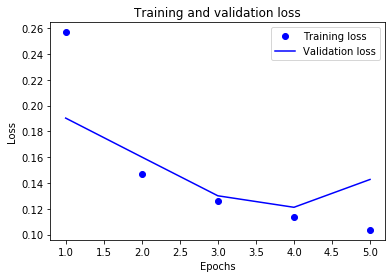

In [67]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

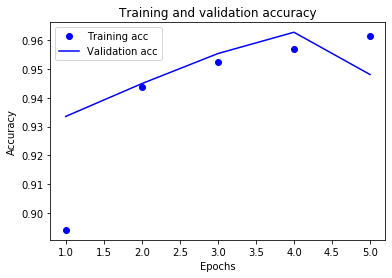

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [73]:
def load_model_keras():
    return load_model(model_name)
model_load = load_model_keras()

/Users/anilnayak/opt/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [74]:
model_load.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_tensor (InputLayer)    (None, 239)               0         
_________________________________________________________________
fc0 (Dense)                  (None, 229)               54960     
_________________________________________________________________
batch_normalization_1 (Batch (None, 229)               916       
_________________________________________________________________
fc1 (Dense)                  (None, 119)               27370     
_________________________________________________________________
batch_normalization_2 (Batch (None, 119)               476       
_________________________________________________________________
fc2 (Dense)                  (None, 1)                 120       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0   

In [75]:
def predict_value(x_p, threshold=0.8):
    prediction_p = model_load.predict(x_p, batch_size=None, verbose=0, steps=None)
    return [1 if prediction_p[i][0] >= threshold else 0 for i in range(len(prediction_p)) ]

In [76]:
# Read All data
file = open('categorical.pkl','rb')
category_data_pkl = pickle.load(file)

In [77]:
file1 = open('mean_std.pkl','rb')
mean_std_data_pkl = pickle.load(file1)

In [78]:
category_data_pkl.keys()

dict_keys(['category', 'main_category', 'currency', 'year_deadline', 'month_deadline', 'year_launched', 'month_launched'])

In [79]:
mean_std_data_pkl.keys()

dict_keys(['mean_data', 'std_data'])

In [80]:
category_data_pkl['main_category']

{'art': 0,
 'comics': 1,
 'crafts': 2,
 'dance': 3,
 'design': 4,
 'fashion': 5,
 'film & video': 6,
 'food': 7,
 'games': 8,
 'journalism': 9,
 'music': 10,
 'photography': 11,
 'publishing': 12,
 'technology': 13,
 'theater': 14}

In [81]:
category_data_pkl['category']

{'3d printing': 0,
 'academic': 1,
 'accessories': 2,
 'action': 3,
 'animals': 4,
 'animation': 5,
 'anthologies': 6,
 'apparel': 7,
 'apps': 8,
 'architecture': 9,
 'art': 10,
 'art books': 11,
 'audio': 12,
 'bacon': 13,
 'blues': 14,
 'calendars': 15,
 'camera equipment': 16,
 'candles': 17,
 'ceramics': 18,
 "children's books": 19,
 'childrenswear': 20,
 'chiptune': 21,
 'civic design': 22,
 'classical music': 23,
 'comedy': 24,
 'comic books': 25,
 'comics': 26,
 'community gardens': 27,
 'conceptual art': 28,
 'cookbooks': 29,
 'country & folk': 30,
 'couture': 31,
 'crafts': 32,
 'crochet': 33,
 'diy': 34,
 'diy electronics': 35,
 'dance': 36,
 'design': 37,
 'digital art': 38,
 'documentary': 39,
 'drama': 40,
 'drinks': 41,
 'electronic music': 42,
 'embroidery': 43,
 'events': 44,
 'experimental': 45,
 'fabrication tools': 46,
 'faith': 47,
 'family': 48,
 'fantasy': 49,
 "farmer's markets": 50,
 'farms': 51,
 'fashion': 52,
 'festivals': 53,
 'fiction': 54,
 'film & video':

In [82]:
list(category_data_pkl['currency'])

['aud',
 'cad',
 'chf',
 'dkk',
 'eur',
 'gbp',
 'hkd',
 'jpy',
 'mxn',
 'nok',
 'nzd',
 'sek',
 'sgd',
 'usd']

In [83]:
x_p = np.array([X_test[5]])
print(np.shape(X_test[5]))
print(np.shape(x_p))
print(predict_value(x_p))

(239,)
(1, 239)
[1]


In [84]:
def prepare_data_for_testing(category, main_category, currency, deadline,
            launched, goal=0, pledged=0, backers=0, usd_pledged=0, usd_pledged_real=0, usd_goal_real=0):
    numerics_data = ([goal, pledged, backers, usd_pledged, usd_pledged_real, usd_goal_real] - mean_std_data_pkl['mean_data']) / mean_std_data_pkl['std_data']

    category_val = [0] * len(list(category_data_pkl['category']))
    category_val[int(category_data_pkl['category'][category])] = 1

    main_category_val = [0] * len(list(category_data_pkl['main_category']))
    main_category_val[int(category_data_pkl['main_category'][main_category])] = 1

    currency_val = [0] * len(list(category_data_pkl['currency']))
    currency_val[int(category_data_pkl['currency'][currency])] = 1

    d_arr = deadline.split("-")
    year_deadline_val = [0] * len(list(category_data_pkl['year_deadline']))
    year_deadline_val[int(category_data_pkl['year_deadline'][d_arr[0]])] = 1

    month_deadline_val = [0] * len(list(category_data_pkl['month_deadline']))
    month_deadline_val[int(category_data_pkl['month_deadline'][d_arr[1]])] = 1

    l_arr = launched.split("-")
    year_launched_val = [0] * len(list(category_data_pkl['year_launched']))
    year_launched_val[int(category_data_pkl['year_launched'][l_arr[0]])] = 1

    month_launched_val = [0] * len(list(category_data_pkl['month_launched']))
    month_launched_val[int(category_data_pkl['month_launched'][l_arr[1]])] = 1

    data_o = list(numerics_data) + list(category_val) + list(main_category_val) + list(currency_val) + list(
        year_deadline_val) + \
             list(month_deadline_val) + list(year_launched_val) + list(month_launched_val)
    data_o = np.array([np.array(data_o, dtype='float')])

    return data_o

In [85]:
# Testing all possible Value : not relevant : unit testing 

for i in list(category_data_pkl['category']):
    for j in list(category_data_pkl['main_category']):
        for k in list(category_data_pkl['currency']):
            
            goal = np.random.randint(low=100.0, high=60000.0, size=None, dtype='l')
            g1 = np.random.randint(low=0.0, high=20000.0, size=None, dtype='l')
            g2 = np.random.randint(low=0.0, high=200.0, size=None, dtype='l')
            g3 = np.random.randint(low=0.0, high=8000.0, size=None, dtype='l')
            g4 = np.random.randint(low=0.0, high=8000.0, size=None, dtype='l')
            g5 = np.random.randint(low=0.0, high=80000.0, size=None, dtype='l')
            data_x = prepare_data_for_testing(i,j,k, '2017-10-10','2016-08-08 12:12:28',goal,g1,g2,g3,g4,g5)

            pred = clf_RandomForest.predict(data_x)
            data_Pred = predict_value([data_x])
            
            break


# Analysis

## Precision, Recall, F1 Score
Citation: http://scikit-learn.org/stable/modules/model_evaluation.html

In [86]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, log_loss, roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import confusion_matrix

In [87]:
x_p = []
y_p = []

for i in range(len(X_test)):
    x_p.append(X_test[i])
    y_p.append(Y_test[i][0])

x_p = np.array(x_p)
y_p = np.array(y_p)

### pred_1 : for NN
### pred_2 : for random forest

In [88]:
pred_2 = clf_RandomForest.predict(x_p)
pred_1 = predict_value(x_p)

In [89]:
precision_recall_fscore_support(y_p, pred_1, average='binary') #micro,weighted,binary

(0.9693176239567992, 0.8757392075694855, 0.9201553398058252, None)

In [90]:
classification_report(y_p, pred_1)

'              precision    recall  f1-score   support\n\n         0.0       0.93      0.98      0.96     24339\n         1.0       0.97      0.88      0.92     13528\n\n    accuracy                           0.95     37867\n   macro avg       0.95      0.93      0.94     37867\nweighted avg       0.95      0.95      0.95     37867\n'

In [91]:
# F1 = 2 * (precision * recall) / (precision + recall)
f1_score(y_p, pred_1,average='binary')

0.9201553398058252

In [92]:
# -log P(yt|yp) = -(yt log(yp) + (1 - yt) log(1 - yp))
log_loss(y_p, pred_1)

1.8753010303687307

In [93]:
roc_auc_score(y_p, pred_1)

0.9301659183416267

In [94]:
# Increasing false positive rates such that element i is the false positive rate of predictions
# Increasing true positive rates such that element i is the true positive rate of predictions

fpr, tpr, thresholds = roc_curve(y_p, pred_1, pos_label=1)
fpr, tpr, thresholds

(array([0.        , 0.01540737, 1.        ]),
 array([0.        , 0.87573921, 1.        ]),
 array([2, 1, 0]))

In [95]:
accuracy_score(y_p, pred_1)

0.9457047033036681

In [96]:
confusion_matrix(y_p, pred_1)

array([[23964,   375],
       [ 1681, 11847]])

In [97]:
confusion_matrix(y_p, pred_1).ravel()
#tp, fn, fp, tn

array([23964,   375,  1681, 11847])

## Correlation


1. Corellation of Attributes
2. Find best attribute to choose from the correlation values
3. highly corrlelated values has to be removed with threshold > 0.8 [Note: I have used all the values]

 

In [98]:
continuous_data.corr()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
goal,1.000000,0.007358,0.004012,0.005567,0.005104,0.942692
pledged,0.007358,1.000000,0.717079,0.856429,0.952843,0.005024
backers,0.004012,0.717079,1.000000,0.697455,0.752539,0.004517
usd pledged,0.005567,0.856429,0.697455,1.000000,0.906639,0.006204
usd_pledged_real,0.005104,0.952843,0.752539,0.906639,1.000000,0.005596
usd_goal_real,0.942692,0.005024,0.004517,0.006204,0.005596,1.000000


In [102]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline
scatter_matrix(continuous_data[['goal', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real','usd_goal_real']],
                        alpha=0.2,
                         figsize=(10, 10)) 
plt.show()

In [103]:
data1.head()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,3D Printing,Academic,Accessories,Action,...,04,05,06,07,08,09,10,11,12,state
0,-0.040630,-0.101248,-0.116423,-0.089027,-0.099578,-0.038094,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,-0.016124,-0.075934,-0.099889,-0.087749,-0.072966,-0.013404,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,-0.003448,-0.098948,-0.113117,-0.086216,-0.097160,-0.000394,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-0.037250,-0.101238,-0.115321,-0.089015,-0.099567,-0.035088,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-0.024997,-0.087833,-0.100991,-0.072631,-0.085475,-0.022511,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


# PCA Analysis

In [104]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
data2 = data1.values
data2_x = data2[:,0:239]
data2_y = data2[:,239:]
print(np.shape(data2_x))
print(np.shape(data2_y))

(378661, 239)
(378661, 1)


In [105]:
pca.fit(data2_x)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [106]:
pca.get_precision()

array([[ 9.10413883e+00, -6.80259030e-03,  3.31908984e-03, ...,
         4.77665565e-02,  1.82967080e-01, -2.53436685e-04],
       [-6.80259030e-03,  1.17713902e+01, -1.29635759e-02, ...,
         2.23808520e-01,  5.83486475e-01, -3.96609731e-01],
       [ 3.31908984e-03, -1.29635759e-02,  2.33626539e+00, ...,
         2.71714562e-02,  5.60630506e-02, -2.07520156e-02],
       ...,
       [ 4.77665565e-02,  2.23808520e-01,  2.71714562e-02, ...,
         8.67871262e+01,  4.12921232e+01, -1.83895389e+00],
       [ 1.82967080e-01,  5.83486475e-01,  5.60630506e-02, ...,
         4.12921232e+01,  8.50288530e+01,  4.27372596e+01],
       [-2.53436685e-04, -3.96609731e-01, -2.07520156e-02, ...,
        -1.83895389e+00,  4.27372596e+01,  9.87976201e+01]])

In [107]:
data1_new = pca.transform(data2_x)

In [108]:
np.shape(data1_new)

(378661, 50)

In [109]:
x1 = X_test[0]

In [110]:
x_1 = pca.transform([x1])

In [111]:
np.shape(x_1)

(1, 50)

In [112]:
x_1[0]

array([ 1.43816137e+01, -1.46963121e-01,  5.58796728e-02, -9.45159378e-01,
       -9.45663176e-01,  5.28949018e-01,  1.37558413e+00,  4.11916774e-01,
       -5.05684891e-01,  4.88709118e-01,  6.93998161e-01,  9.28459189e-01,
       -4.64865806e-02,  6.25893459e-01,  8.12700361e-01,  1.07467173e+00,
        2.84435567e+00, -4.55010329e-01,  8.75561313e-01, -2.17979989e-01,
        7.99619783e-01,  9.34526400e-01, -4.78663295e-01, -4.35372522e-02,
       -6.69764255e-01, -2.75009187e-01, -2.19917786e-01,  7.50538981e-02,
       -2.94813297e-02, -4.21450108e-02, -2.78689705e-01, -1.00815155e-01,
        8.17925749e-02, -4.72762898e-02, -1.76047844e-01, -1.57936586e-01,
        1.29837942e-02, -3.05453697e-02, -1.46502314e-01, -1.01024557e-02,
       -2.75403951e-01, -1.28672864e+00, -4.59176628e-01, -6.12418147e-02,
        8.62362952e-02, -2.55839245e-03,  1.47480401e-02,  9.61105822e-03,
       -4.68401310e-02, -3.84741303e-02])

# Model
1. Model traied Random Forest and Neural Network
2. Validated Neural Network model with the benchmark model Random Forest

# Performance Metrics
1. validation loss and testing loss is low
2. All the model surpass the human level error assumed as 0.15
3. As the Validation and Testing Accuracy is very much close and the Neural Network model is evaluated in comparision with the benchmark model Random Forest
4. Evaluation is mentioned below

# Training
1. Training done for 5 epochs

# Evaluation
1. Random Forest is giving 98% accuracy
2. Neural Network is giving 97% accuracy

# Saving Model
1. random_forest model saved in "random_forest_model_features.pkl"
2. Keras model saved in "model_keras.h5"
3. Categorical Data info dictionary saved in "categorical.pkl" 
4. Continuous value normalization details saved in "mean_std.pkl" with keys "mean_data" and "std_data"

# Project Contains
|Module |Functionality|
|------------|-------------|
|training.py |[train model]|
|testing.py |[test model]|
|load_data.py |[load, normalize, onehot encoding,prepare data]|
|MLP.py |[MLP model, training, evaluation]|
|random_forest.py |[random forest model, training, evaluation]|
|tensorflow_model.py |[tensorflow model, training, evaluation]|
|keras_model.py |[keras model, training, evaluation]|

# Directory and module Details

### Testing -> testing.py

1. to test the application you have to prepare the data first. this can be done by using load_data.py -> prepare_live_test_data()
2. using testing.py, user can test the model

```python
#Import following modules
import random_forest as rf
import load_data as ld
import keras_model as km

# Data Handler object to load the data for training or loading pickle files for testing
# pca_decompose=True, at testing time inut will be decomposed 
ld_obj = ld.DataHandler(pca_decompose=False)


#loading pickle file to get the normalization details mean and std / category information to form the one hot encoding
ld_obj.load_pickle_data()

# Preparing data for testing
data = ld_obj.prepare_live_test_data(category='academic',
									 main_category='comics',
									 currency='usd',
									 deadline='2017-10-10',
									 launched='2016-08-08 12:12:28',
									 goal=0,
									 pledged=0,
									 backers=0,
									 usd_pledged=0,
									 usd_pledged_real=0,
									 usd_goal_real=0)

class Testing():
	def __init__(self, ld_obj):
		self.ld_obj = ld_obj
		self.keras_model = None
		self.random_forest = None
	
	def load_random_forest(self):
		self.random_forest = rf.RandomForest(self.ld_obj)
		self.random_forest.load_model()
	
	def load_nn(self):
		self.keras_model = km.KerasModel(self.ld_obj)
		self.keras_model.load_model_keras()

	def predict(self, x):
		print("Keras Model: ", self.keras_model.predict(x))
		print("Random Forest Model: ", self.random_forest.predict(x))
		
# Small testing app to test all the model
tst = Testing(ld_obj)
# Loading random forest model into application
tst.load_random_forest()
# Loading neural network model into application
tst.load_nn()
# predicting the data prepared for using both the models
tst.predict(data)
```



### Data Handler ->  load_data.py
1. loading data from file and clean data for null values and blanks

```python
def load_data(self, file_name, keep_attribute)
# file_name : data file csv
# keep_attribute : list of attribute list to keey for data analysis
#output
#self.continuous_data = None
#self.categorical_data = None
```
2. normalize continuous values columns

```python
def normalize_continuous_data(self)
#self.continuous_data = None
#saves the mean and std data in mean_std.pkl file
```

3. one hot encoding for categorical data

```python
def one_hot_encoding_categorical_data(self, categories, date_attributes)

#categories : list of categorical columns for which one hot encoding will be done
#date_attributes : date columns for which one hot encoding will be done for Year and Month values [not day value]
```

4. convert target column encoding

```python
def one_hot_encode_target_value(self, target='state', success_class='successful')

#target : target column used for encoding
#success_class: this value used for making target column value 1 and other set to 0
```

5. prepare training, testing, validation data split

```python
def prepare_data(self, test_data_perc=0.2)

#test_data_perc : test data percentage split training=80%, testing=10% and validation=10%
```

5. loading pickle file for testing

```python

def load_pickle_data(self)

#load 'categorical.pkl' for categorical data conversion
#load 'mean_std.pkl' for normalization of testing data
```

6. preparing unseen testing data

```python
def prepare_live_test_data(self, category, main_category, currency, deadline,
				launched, goal=0, pledged=0, backers=0, usd_pledged=0, usd_pledged_real=0, usd_goal_real=0)

#all the attributes are column names from data used for model training
```

### Training ->  training.py

```python

# pca_decompose=False, num_feature_to_decompose=50
# PCA will be done if the flag pca_decompose is set True
class Train():
	def __init__(self, file_name, filter_attribute, pca_decompose=False, num_feature_to_decompose=50):
		self.ld_obj = ld.DataHandler(pca_decompose=pca_decompose,num_feature_to_decompose=num_feature_to_decompose)
		self.file_name = file_name
		self.filter_attribute = filter_attribute
		self.features = None
		self.classes = None
        
    .........

# load file name
file_name = 'data.csv'

#attributes used for training
filter_attribute = ['category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'state',
					'backers', 'usd pledged', 'usd_pledged_real', 'usd_goal_real']

# Training Object
training_obj = Train(file_name, filter_attribute)

# loading data 
training_obj.loaddata()

#normalizing continuous values columns
training_obj.normalize_continuous_data()

#categorical columns to be used for one hot encoding
categories = ['category', 'main_category', 'currency']

#date columns to be used for one hot encoding only [Year, Month]
date_attributes = ['deadline', 'launched']

# One hot encoding for all categorical values, this function will save the pickle files as well
training_obj.one_hot_encoding_categorical_data(categories, date_attributes, target='state', success_class='successful')

# visualize the data and split the data 
print(training_obj.ld_obj.data.head())
training_obj.spilt_data()

print("Training Random Forest model")
training_obj.random_forest()

print("Training Tensorflow model ")
training_obj.tensorflow_model()

print("Training Keras model ")
training_obj.keras_model()
```

# Usage

1. Run training.py  [as mentioned in the section (Directory and module Details -> Training )]
    i. file_name, filter_attribute, pca_decompose=False, num_feature_to_decompose=50 
2. Run testing.py [as mentioned in the section (Directory and module Details -> Testing)]
    i. if pca_decompose=True while training then while testing pca_decompose=True also holds